### Import data

In [1]:
import pickle
import numpy as np

def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data

files = []
for n in range(1, 33):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

labels = []
data = []
for i in files:
    filepath = "archive/data_preprocessed_python/s" + i + ".dat"
    d = read_data(filepath)
    labels.append(d['labels'])
    data.append(d['data'])



#### Reshape data

In [2]:

labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)
labels = labels.reshape(1280, 4)
data = data.reshape(1280, 40, 8064)
print(labels.shape)
print(data.shape)
eeg_data = data[:,:32,:]
print(eeg_data.shape)


(32, 40, 4)
(32, 40, 40, 8064)
(1280, 4)
(1280, 40, 8064)
(1280, 32, 8064)


#### Encode labels

In [3]:
label_name = ["valence","arousal"]
labels_valence = []
labels_arousal = []

for la in labels:
    if la[0] < 3:
        labels_valence.append("LOW")
    elif 3 <= la[0] < 6:
        labels_valence.append("MEDIUM")
    else:
        labels_valence.append("HIGH")
    
    if la[1] < 3:
        labels_arousal.append("LOW")
    elif 3 <= la[1] < 6:
       labels_arousal.append("MEDIUM")
    else:
        labels_arousal.append("HIGH")

combined_labels = np.array([labels_valence[i] +'_' + labels_arousal[i] for i in range(len(labels_valence))]).reshape(-1,1)


from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(combined_labels)
enc.categories_
yData_enc = enc.transform(combined_labels).reshape(-1)

num_categories = len(np.unique(yData_enc))
num_categories

9

#### Model definition - based on convolution

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class EEGClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super(EEGClassifierCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully connected layer
        self.fc1 = nn.Linear(256 * (8064 // 8), 512)  # Adjust to account for pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)  # 9 classes
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # Get index of the max log-probability
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

# Instantiate the model
model = EEGClassifierCNN(num_categories)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

EEGClassifierCNN(
  (conv1): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=258048, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)


#### Model training

In [5]:
xData = eeg_data

# Hyperparameters
learning_rate = 0.002
num_epochs = 5
batch_size = 32

# Convert to PyTorch tensors
xData_tensor = torch.tensor(xData, dtype=torch.float32)
yData_tensor = torch.tensor(yData_enc, dtype=torch.long)  # For classification, labels should be long

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(xData_tensor, yData_tensor, test_size=0.2, random_state=42)


# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i + batch_size]
        batch_y = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_accuracy = calculate_accuracy(val_outputs, y_val)
    
    print(f'Epoch [eval{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'classifier_model.pth')

Epoch [eval1/5], Loss: 7.9676, Val Loss: 4.3728, Val Accuracy: 0.2305
Epoch [eval2/5], Loss: 2.2410, Val Loss: 2.2839, Val Accuracy: 0.1953
Epoch [eval3/5], Loss: 2.5178, Val Loss: 2.1632, Val Accuracy: 0.2031
Epoch [eval4/5], Loss: 2.0394, Val Loss: 2.3962, Val Accuracy: 0.1992
Epoch [eval5/5], Loss: 2.1296, Val Loss: 2.1621, Val Accuracy: 0.1797


C:\Users\josebencao9\AppData\Local\Temp\ipykernel_15260\349629132.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = model(torch.tensor(X_val, dtype=torch.float32))


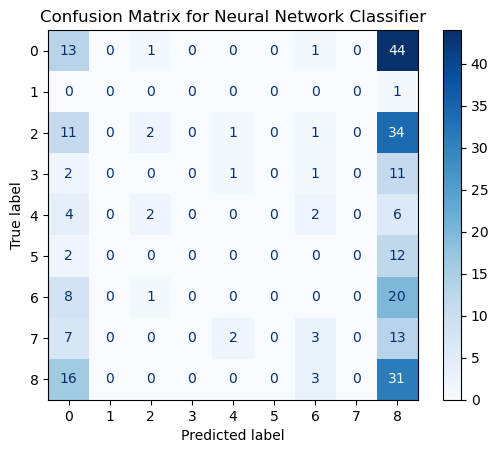

               precision    recall  f1-score   support

    HIGH_HIGH       0.21      0.22      0.21        59
     HIGH_LOW       0.00      0.00      0.00         1
  HIGH_MEDIUM       0.33      0.04      0.07        49
     LOW_HIGH       0.00      0.00      0.00        15
      LOW_LOW       0.00      0.00      0.00        14
   LOW_MEDIUM       0.00      0.00      0.00        14
  MEDIUM_HIGH       0.00      0.00      0.00        29
   MEDIUM_LOW       0.00      0.00      0.00        25
MEDIUM_MEDIUM       0.18      0.62      0.28        50

     accuracy                           0.18       256
    macro avg       0.08      0.10      0.06       256
 weighted avg       0.15      0.18      0.12       256



c:\Users\josebencao9\miniconda3\envs\faip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josebencao9\miniconda3\envs\faip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josebencao9\miniconda3\envs\faip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Predict the labels for the test set using the neural network model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(torch.tensor(X_val, dtype=torch.float32))
    _, y_pred = torch.max(y_pred_tensor, 1)
    y_pred = y_pred.numpy()

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Neural Network Classifier')
plt.show()

# Generate a classification report
report = classification_report(y_val, y_pred, target_names=enc.categories_[0])
print(report)

#### Test model 

In [11]:
# Model in evaluation mode
model.eval()

sampleIDX = 1

# Get the first sample from the testing set
sample_X = X_val[sampleIDX]
sample_y = y_val[sampleIDX]

# Convert the sample to a PyTorch tensor and reshape to match the model's input dimensions
sample_X_tensor = torch.tensor(sample_X, dtype=torch.float32).unsqueeze(0)

# Perform a forward pass to get the model's prediction
with torch.no_grad():
    output = model(sample_X_tensor)
    _, predicted = torch.max(output, 1)

# Print the actual and predicted labels
print(f'Actual label: {enc.inverse_transform(sample_y.reshape(1,-1))}')
print(f'Neural Network Predicted label: {enc.inverse_transform(predicted.reshape(1,-1))}')


C:\Users\josebencao9\AppData\Local\Temp\ipykernel_15260\2802075950.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_X_tensor = torch.tensor(sample_X, dtype=torch.float32).unsqueeze(0)


Actual label: [['MEDIUM_MEDIUM']]
Neural Network Predicted label: [['MEDIUM_MEDIUM']]
